Deep Learning
=============

Assignment 2
------------

Previously in `1_notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

In [1]:
import tensorflow as tf
tf.__version__

'1.2.1-rc1'

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

First reload the data we generated in `1_notmnist.ipynb`.

In [3]:
pickle_file = '/home/victor/data/notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.

In [4]:
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


### `a[:,None]` equivalente à `a.reshape(-1,1)`

### A dimensão dos vetores acima é:  
- #### dado=(número de objetos, número de features)  #
- #### labels=(número de objetos, número de classes) #

In [5]:
train_labels[3,:]

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

We're first going to train a multinomial logistic regression using simple gradient descent.

TensorFlow works like this:
* First you describe the computation that you want to see performed: what the inputs, the variables, and the operations look like. These get created as nodes over a computation graph. This description is all contained within the block below:

      with graph.as_default():
          ...

* Then you can run the operations on this graph as many times as you want by calling `session.run()`, providing it outputs to fetch from the graph that get returned. This runtime operation is all contained in the block below:

      with tf.Session(graph=graph) as session:
          ...

Let's load all the data into TensorFlow and build the computation graph corresponding to our training:

In [24]:
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run this computation and iterate:

In [26]:
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
      predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
      print(' ')
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 17.322098
Training accuracy: 11.2%
Validation accuracy: 13.1%
 
Loss at step 100: 2.266381
Training accuracy: 72.8%
Validation accuracy: 70.5%
 
Loss at step 200: 1.834254
Training accuracy: 75.4%
Validation accuracy: 72.8%
 
Loss at step 300: 1.601070
Training accuracy: 76.6%
Validation accuracy: 73.9%
 
Loss at step 400: 1.443264
Training accuracy: 77.4%
Validation accuracy: 74.1%
 
Loss at step 500: 1.324929
Training accuracy: 77.9%
Validation accuracy: 74.3%
 
Loss at step 600: 1.231132
Training accuracy: 78.5%
Validation accuracy: 74.6%
 
Loss at step 700: 1.154312
Training accuracy: 78.9%
Validation accuracy: 74.8%
 
Loss at step 800: 1.089887
Training accuracy: 79.3%
Validation accuracy: 75.0%
 
Test accuracy: 82.6%


train_subset = 50000
Initialized
Loss at step 0: 15.193044
Training accuracy: 8.2%
Validation accuracy: 13.7%
Loss at step 100: 1.129415
Training accuracy: 86.1%
Validation accuracy: 27.8%
Loss at step 200: 0.899339
Training accuracy: 87.6%
Validation accuracy: 28.0%
Loss at step 300: 0.773293
Training accuracy: 88.2%
Validation accuracy: 28.1%
Loss at step 400: 0.687697
Training accuracy: 88.6%
Validation accuracy: 28.0%
Loss at step 500: 0.623733
Training accuracy: 88.8%
Validation accuracy: 27.9%
Loss at step 600: 0.573386
Training accuracy: 89.1%
Validation accuracy: 27.8%
Loss at step 700: 0.532616
Training accuracy: 89.3%
Validation accuracy: 27.6%
Loss at step 800: 0.498989
Training accuracy: 89.5%
Validation accuracy: 27.6%
Test accuracy: 28.9%

Let's now switch to stochastic gradient descent training instead, which is much faster.

The graph will be similar, except that instead of holding all the training data into a constant node, we create a `Placeholder` node which will be fed actual data at every call of `session.run()`.

In [27]:
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

Let's run it:

In [28]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      print(' ')
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 13.791849
Minibatch accuracy: 11.7%
Validation accuracy: 13.4%
 
Minibatch loss at step 500: 1.590794
Minibatch accuracy: 73.4%
Validation accuracy: 75.2%
 
Minibatch loss at step 1000: 1.275118
Minibatch accuracy: 78.1%
Validation accuracy: 76.3%
 
Minibatch loss at step 1500: 1.343654
Minibatch accuracy: 69.5%
Validation accuracy: 77.1%
 
Minibatch loss at step 2000: 0.735087
Minibatch accuracy: 79.7%
Validation accuracy: 77.9%
 
Minibatch loss at step 2500: 0.855441
Minibatch accuracy: 78.1%
Validation accuracy: 78.5%
 
Minibatch loss at step 3000: 1.344349
Minibatch accuracy: 69.5%
Validation accuracy: 78.1%
 
Test accuracy: 85.7%


---
Problem
-------

Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units [nn.relu()](https://www.tensorflow.org/versions/r0.7/api_docs/python/nn.html#relu) and 1024 hidden nodes. This model should improve your validation / test accuracy.

---

In [49]:
batch_size = 128

# Numero de 'hidden nodes' exigido pelo problema. Verificaremos se essa escolha será eficiente, ou seja, se a acurácia
# irá aumentar
number_nodes = 1024

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # Os dados entram no neuronio que tem number_nodes neuronios internos
  weights_nodes_in = tf.Variable(
    tf.truncated_normal([image_size * image_size, number_nodes]))
  biases_nodes_in = tf.Variable(tf.zeros([number_nodes]))
  # Agora, a saida do neuronio é o input para o peso a ser calculado pelo modelo, otimizado via SGD
  # Assim a entrada deixa de ser cada imagem e passa a ser a saida do neuronio
  weights = tf.Variable(
    tf.truncated_normal([number_nodes, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits_nodes = tf.nn.relu(tf.matmul(tf_train_dataset, weights_nodes_in) + biases_nodes_in)
  # Primeiro é feita o cálculo no 'neuronio' e sua saída é usada no calculo seguinte
  logits = tf.matmul(logits_nodes, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  # O calculo para os datasets de validação e teste devem ser feitos de maneira idêntica ao treinamento, ou seja,
  # deve-se levar em conta que primeiro o dataset passa pela rede neural (1 neuronio nesse caso) e seu output segue para
  # o calculo do SGD
  valid_nodes = tf.nn.relu(tf.matmul(tf_valid_dataset, weights_nodes_in) + biases_nodes_in)
  valid_prediction = tf.nn.softmax(
    tf.matmul(valid_nodes, weights) + biases)
  test_nodes = tf.nn.relu(tf.matmul(tf_test_dataset, weights_nodes_in) + biases_nodes_in)
  test_prediction = tf.nn.softmax(tf.matmul(test_nodes, weights) + biases)
# Para facilitar, o nome final das variaveis (resultados) foi mantido inalterado em relação ao exemplo anterior, assim
# fica mais rapido fazer as alterações para resolver o que o problema pede e tentar ajustes para melhorar o resultado 
# final.


In [50]:
num_steps = 3001

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

print("-----------------TESTE PARA REDE NEURAL COM 1 NEURÔNIO COM 1024 NODES INTERNOS-----------------")
with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
      print(' ')
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

-----------------TESTE PARA REDE NEURAL COM 1 NEURÔNIO COM 1024 NODES INTERNOS-----------------
Initialized
Minibatch loss at step 0: 292.622131
Minibatch accuracy: 5.5%
Validation accuracy: 24.2%
 
Minibatch loss at step 500: 13.617745
Minibatch accuracy: 82.0%
Validation accuracy: 78.7%
 
Minibatch loss at step 1000: 17.567371
Minibatch accuracy: 71.9%
Validation accuracy: 72.4%
 
Minibatch loss at step 1500: 23.762470
Minibatch accuracy: 74.2%
Validation accuracy: 78.6%
 
Minibatch loss at step 2000: 4.461239
Minibatch accuracy: 81.2%
Validation accuracy: 81.0%
 
Minibatch loss at step 2500: 3.250837
Minibatch accuracy: 82.0%
Validation accuracy: 82.3%
 
Minibatch loss at step 3000: 2.736144
Minibatch accuracy: 78.1%
Validation accuracy: 82.2%
 
Test accuracy: 89.3%


In [ ]:
NODES Test accuracy:
16 86.5
32 85.2
64 87.3
128 86.4
256  87.7
512 86.3
1024 86.0
2048 87.9

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
nodes_size = 2**np.arange(4,12)

In [38]:
test_accuracy_final = np.array([86.5, 85.2, 87.3, 86.4, 87.7, 86.3, 86.0, 87.9])

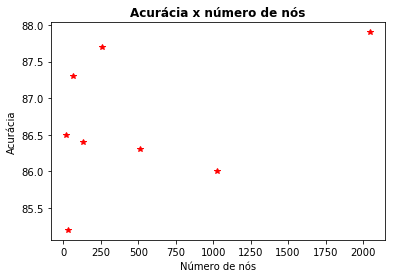

In [48]:
plt.figure()
plt.plot(nodes_size,test_accuracy_final, '*r')
plt.xlabel('Número de nós')
plt.ylabel('Acurácia')
plt.title('Acurácia x número de nós', fontweight='bold', )

### Apesar das variações observadas, para o caso específico que o problema pede (1024 nós) a acurácia obtida foi de 86 % enquanto que para o SGD sem rede neuronal obete-ve 85.7%. Ou seja, não obteve-se um aumento significativo da acurácia. 

### É interessantes notar, pelo gráfico acima, que pode-se obter resultados melhores com menos camadas (nós). Observa-se também que para 2048 nós chegou-se em resultado melhor (em valor absoluto), mas com número bem menor de nós pode-se obter uma acurácia da mesma ordem (com 256 nós a acurácia foi de 87.7%).

### Para um resultado melhor ainda provavelmente só será possível usando mais camadas (neurônios) e também técnicas de regularização (tema do próximo assignment do curso do Udacity).